In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.8 MB/s eta 0:00:00


In [2]:
# Standard library imports
import os
import random
import warnings
import copy
from collections import Counter

# Third-party imports
import cv2
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom

# Machine learning imports
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset,
)

# Torchvision imports
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

In [3]:
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"- {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

GPUs Available: 1
- Tesla P100-PCIE-16GB


In [4]:
"""
Ignore this warning
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
"""
warnings.filterwarnings('ignore', category=RuntimeWarning, message='os.fork()')

# Local

In [5]:
# ## Dataset and Directory Configuration
# DATASET_NAME = 'rsna-mil-training'
# JOB_NAME = 'RSNA-ResNet18'
# HPC_DIR = '/media02/tdhoang01/21127112-21127734/data'
# OUTPUT_DIR = '/media02/tdhoang01/python-debugging/rsna/results'

# ZIP_FILE_PATH = os.path.join(HPC_DIR, DATASET_NAME + '.zip')
# CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
# FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
# DICOM_DIR = f'{DATASET_NAME}/'

# ## File Paths
# CSV_PATH = f'{DATASET_NAME}/training_1000_scan_subset.csv'

# ## Image Processing Parameters
# MAX_SLICES = 60
# HEIGHT = 224
# WIDTH = 224

# ## Training Hyperparameters
# BATCH_PATIENTS = 4
# NUM_EPOCHS = 2
# LEARNING_RATE = 1e-4

# ## Dataset Split Ratios
# VAL_SIZE = 0.15
# TEST_SIZE = 0.15

# ## Create Necessary Directories
# os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
# os.makedirs(FIGURES_DIR, exist_ok=True)

# ## Load CSVs from zip
# with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
#     medical_scan_data = pd.read_csv(zip_ref.open(CSV_PATH))

# Kaggle

In [6]:
# Configuration
DATASET_NAME = 'rsna-mil-training'
JOB_NAME = 'RSNA-ResNet18'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# Directories
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
DICOM_DIR = os.path.join(INPUT_DIR, DATASET_NAME, DATASET_NAME)

# File Paths
CSV_PATH = f'{DICOM_DIR}/training_1000_scan_subset.csv'

# Image Processing Parameters
MAX_SLICES = 60
HEIGHT = 224
WIDTH = 224
CHANNELS = 1

# Training Hyperparameters
BATCH_PATIENTS = 8
NUM_EPOCHS = 20
LEARNING_RATE = 5e-5
THRESHOLD = 0.6

# Early stopping
PATIENCE = 5
MIN_DELTA = 1e-4

# Dataset Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Create Necessary Directories
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load CSV from Kaggle environment (no need to unzip)
medical_scan_data = pd.read_csv(CSV_PATH)

# Random seed
SEED = 42

# Augmentation levels
N_LEVELS = 3

In [7]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
medical_scan_data.head(1)

patient_id study_instance_uid  \
0  ID_2e010e33      ID_bda0f47e84   

                                              images  \
0  ['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...   

                                              labels  patient_label  length  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              0      48

In [9]:
medical_scan_data.columns

Index(['patient_id', 'study_instance_uid', 'images', 'labels', 'patient_label',
       'length'],
      dtype='object')

# Split sets in dataframe

In [10]:
def split_dataset(medical_scan_data, val_size, test_size, seed):
    # Calculate total number of samples
    total_samples = len(medical_scan_data)

    # Calculate the number of samples for validation and testing
    num_val_samples = int(val_size * total_samples)
    num_test_samples = int(test_size * total_samples)

    # Split the dataset into training and temp (validation + test)
    train_data, temp_data = train_test_split(
        medical_scan_data,
        test_size=(num_val_samples + num_test_samples) / total_samples,
        stratify=medical_scan_data['patient_label'],
        random_state=seed
    )

    # Now split temp into validation and test sets
    validate_data, test_data = train_test_split(
        temp_data,
        test_size=num_test_samples / (num_val_samples + num_test_samples),
        stratify=temp_data['patient_label'],
        random_state=seed
    )

    return train_data.reset_index(drop=True), validate_data.reset_index(drop=True), test_data.reset_index(drop=True)

# Data augmentation

In [11]:
class DatasetAugmentor:
    def __init__(self, height, width, n_levels=3, channels=3, seed=None):
        self.height = height
        self.width = width
        self.n_levels = n_levels
        self.channels = channels
        self.seed = seed
        
        # Create parameters for levels from 0 to n_levels - 1
        self.params = [self._create_transform(level) for level in range(n_levels)]
        
        self.print_params()

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, level):
        base_degrees = 15
        base_translate = (0.2, 0.2)
        base_scale = (0.9, 1.2)
        base_brightness = 0.2
        base_contrast = 0.2
        base_blur_sigma = (0.1, 0.6)

        scale_factor = (level + 1) / self.n_levels

        sampled_degrees = abs(self._sample_value((-base_degrees * scale_factor, base_degrees * scale_factor)))
        sampled_translate_x = abs(self._sample_value((base_translate[0] * scale_factor)))
        sampled_translate_y = abs(self._sample_value((base_translate[1] * scale_factor)))
        sampled_scale = self._sample_value((
            base_scale[0] + (base_scale[1] - base_scale[0]) * scale_factor,
            base_scale[0] + (base_scale[1] - base_scale[0]) * scale_factor
        ))
        sampled_brightness = self._sample_value((0, base_brightness * scale_factor))
        sampled_contrast = self._sample_value((0, base_contrast * scale_factor))        
        sampled_blur_sigma = self._sample_value((
            base_blur_sigma[0] + (base_blur_sigma[1] - base_blur_sigma[0]) * scale_factor,
            base_blur_sigma[0] + (base_blur_sigma[1] - base_blur_sigma[0]) * scale_factor
        ))
        
        return {
            "degrees": sampled_degrees,
            "translate": (sampled_translate_x, sampled_translate_y),
            "scale": sampled_scale,
            "brightness": sampled_brightness,
            "contrast": sampled_contrast,
            "blur_sigma": sampled_blur_sigma,
            "apply_elastic": level > 0
        }

    def apply_transform(self, image, level):        
        if self.seed is not None:
            torch.manual_seed(self.seed)
            random.seed(self.seed)

        # Check if level is within the valid range of 0 to n_levels - 1
        if level < 0 or level >= self.n_levels:
            raise ValueError(f"Level must be between 0 and {self.n_levels - 1}")

        params = self.params[level]
        transform = self._get_transform(params)

        transformed_image = transform(image)        
        return transformed_image

    def _get_transform(self, params):
        normalization_mean_std = {
            1: ([0.16774411], [0.3101935]),
            3: ([0.16774411, 0.1360026, 0.19076315], [0.3101935, 0.27605791, 0.30469988])
        }

        mean, std = normalization_mean_std.get(self.channels, ([0], [1]))

        # Create a list of transformations
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]

        if self.channels > 1:
            transform_list.append(transforms.RandomApply([self._channel_shuffle], p=0.3))

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

    def print_params(self):
        for i, param in enumerate(self.params):
            print(f"Level {i}:")
            print(f"  Degrees: {param['degrees']}")
            print(f"  Translation: (X: {param['translate'][0]}, Y: {param['translate'][1]})")
            print(f"  Scale: {param['scale']}")
            print(f"  Brightness Adjustment: {param['brightness']}")
            print(f"  Contrast Adjustment: {param['contrast']}")
            print(f"  Blur Sigma: {param['blur_sigma']}")
            print(f"  Apply Elastic Transform: {'Yes' if param['apply_elastic'] else 'No'}")
            print("-" * 10)

In [12]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, seed=SEED, n_levels=N_LEVELS, channels=CHANNELS)

Level 0:
  Degrees: 1.3942679845788373
  Translation: (X: 0.06666666666666667, Y: 0.06666666666666667)
  Scale: 1.0
  Brightness Adjustment: 0.04262845323052558
  Contrast Adjustment: 0.04262845323052558
  Blur Sigma: 0.26666666666666666
  Apply Elastic Transform: No
----------
Level 1:
  Degrees: 2.7885359691576745
  Translation: (X: 0.13333333333333333, Y: 0.13333333333333333)
  Scale: 1.1
  Brightness Adjustment: 0.08525690646105116
  Contrast Adjustment: 0.08525690646105116
  Blur Sigma: 0.43333333333333335
  Apply Elastic Transform: Yes
----------
Level 2:
  Degrees: 4.182803953736514
  Translation: (X: 0.2, Y: 0.2)
  Scale: 1.2
  Brightness Adjustment: 0.12788535969157674
  Contrast Adjustment: 0.12788535969157674
  Blur Sigma: 0.6
  Apply Elastic Transform: Yes
----------


# Local dataset gen.

# Kaggle dataset gen.

In [13]:
class MedicalScanDataset(Dataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor=None, n_levels=N_LEVELS):
        self.dicom_dir = dicom_dir
        self.medical_scan_data = self._parse_medical_scan_data(medical_scan_data)
        self.max_slices = max_slices
        self.height = height
        self.width = width
        self.augmentor = augmentor
        self.n_levels = n_levels
        
    def __len__(self):
        return len(self.medical_scan_data) * (self.n_levels if self.augmentor else 1)

    def __getitem__(self, idx):
        if self.augmentor:
            base_idx = idx // self.n_levels
            augment_level = idx % self.n_levels
        else:
            base_idx = idx
            augment_level = None

        row = self.medical_scan_data.iloc[base_idx]
        dicom_files = self._get_dicom_files(row)

        labels = torch.tensor(row['labels'], dtype=torch.float32)
        patient_label = torch.tensor(row['patient_label'], dtype=torch.float32)

        images = [self._process_dicom_file(dicom_file) for dicom_file in dicom_files]

        while len(images) < self.max_slices:
            images.append(torch.zeros(CHANNELS, self.height, self.width))
        
        image_tensor = torch.stack(images[:self.max_slices])

        if len(labels) < self.max_slices:
            label_padding = torch.zeros(self.max_slices - len(labels), dtype=torch.float32)
            labels = torch.cat((labels, label_padding))

        if augment_level is not None:
            image_tensor = torch.stack([self.augmentor.apply_transform(image, augment_level) for image in image_tensor])

        return image_tensor, labels, patient_label

    def _parse_medical_scan_data(self, medical_scan_data):
        medical_scan_data['images'] = medical_scan_data['images'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['labels'] = medical_scan_data['labels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['patient_label'] = medical_scan_data['patient_label'].astype(bool)
        return medical_scan_data

    def _get_dicom_files(self, row):
        """Retrieve and sort DICOM files by z-coordinate."""
        patient_id = row['patient_id'].replace("ID_", "")
        study_instance_uid = row['study_instance_uid'].replace("ID_", "")
        dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")

        dicom_files = []
        if os.path.exists(dicom_dir_path):
            slices = []
            for image in row['images']:
                dicom_file_path = os.path.join(dicom_dir_path, image)
                if os.path.exists(dicom_file_path):
                    slices.append(dicom_file_path)

            dicom_files = sorted(slices, key=lambda x: float(pydicom.dcmread(x).ImagePositionPatient[2]) if hasattr(pydicom.dcmread(x), 'ImagePositionPatient') else 0)

        return dicom_files

    def _process_dicom_file(self, dicom_file):
        """Load and preprocess a DICOM file."""
        try:
            dicom = pydicom.dcmread(dicom_file)
            img = self._preprocess_slice(dicom)
            return torch.from_numpy(img).float()
        except Exception as e:
            print(f"Error processing {dicom_file}: {e}")
            return torch.zeros(CHANNELS, self.height, self.width)

    def _preprocess_slice(self, dicom):
        """Apply windowing to extract relevant image data."""
        brain_img = self._window_image(dicom, 40, 80)
        subdural_img = self._window_image(dicom, 80, 200)
        soft_img = self._window_image(dicom, 40, 380)

        if CHANNELS == 3:
            normalized_images = np.array([
                (brain_img - 0) / 80,
                (subdural_img - (-20)) / 200,
                (soft_img - (-150)) / 380
            ])
            
        elif CHANNELS == 1:
            normalized_images = np.array([
                (brain_img - 0) / 80,
            ])
        
        return normalized_images.astype(np.float16)

    def _window_image(self, dcm, window_center, window_width):
        """Apply windowing and resize the DICOM image."""
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        return cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)

    def calculate_mean_std(self):
        """Calculate mean and standard deviation across dataset."""
        total_mean = np.zeros(3)
        total_var = np.zeros(3)
        total_count = 0
        
        for idx in range(len(self.medical_scan_data)):
            row = self.medical_scan_data.iloc[idx]
            dicom_files = self._get_dicom_files(row)
            
            for dicom_file in dicom_files:
                img = self._process_dicom_file(dicom_file)
                img_np = img.numpy()
                
                if np.all(img_np == 0):
                    continue
                
                mean = np.mean(img_np, axis=(1, 2))
                var = np.var(img_np, axis=(1, 2))
                
                total_count += img_np.shape[1] * img_np.shape[2]
                total_mean += mean * (img_np.shape[1] * img_np.shape[2])
                total_var += var * (img_np.shape[1] * img_np.shape[2]) + (mean**2) * (img_np.shape[1] * img_np.shape[2])
        
        final_mean = total_mean / total_count
        final_var = total_var / total_count - (final_mean**2)
        final_std = np.sqrt(final_var)

        return final_mean, final_std

In [14]:
class TrainDatasetGenerator(MedicalScanDataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor=None, n_levels=N_LEVELS):
        super().__init__(dicom_dir, medical_scan_data, max_slices, height, width, augmentor=augmentor, n_levels=n_levels)

class ValidateDatasetGenerator(MedicalScanDataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor=None, n_levels=N_LEVELS):
        super().__init__(dicom_dir, medical_scan_data, max_slices, height, width, augmentor=augmentor, n_levels=n_levels)

class TestDatasetGenerator(MedicalScanDataset):
    def __init__(self, dicom_dir, medical_scan_data, max_slices, height, width, augmentor=None, n_levels=N_LEVELS):
        super().__init__(dicom_dir, medical_scan_data, max_slices, height, width, augmentor=augmentor, n_levels=n_levels)

In [15]:
train_df, validate_df, test_df = split_dataset(medical_scan_data, VAL_SIZE, TEST_SIZE, seed=SEED)

# Train, Valid, Test generator

augmentor = None for no augmentation

In [16]:
# Initialize dataset generators with the respective DataFrames
train_dataset_generator = TrainDatasetGenerator(
    dicom_dir=DICOM_DIR,
    medical_scan_data=train_df,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    augmentor=augmentor,
)

validate_dataset_generator = ValidateDatasetGenerator(
    dicom_dir=DICOM_DIR,
    medical_scan_data=validate_df,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    augmentor=None,
)

test_dataset_generator = TestDatasetGenerator(
    dicom_dir=DICOM_DIR,
    medical_scan_data=test_df,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    augmentor=None,
)

In [17]:
images, labels, patient_label = train_dataset_generator[0]
print(images.shape, labels.shape, patient_label.shape)

torch.Size([60, 1, 224, 224]) torch.Size([60]) torch.Size([])


In [18]:
print(len(train_dataset_generator), len(validate_dataset_generator), len(test_dataset_generator))

2100 150 150


# Dataloader

In [19]:
class DataloaderManager:
    def __init__(self,
                 train_dataset_generator: TrainDatasetGenerator,
                 validate_dataset_generator: ValidateDatasetGenerator,
                 test_dataset_generator: TestDatasetGenerator,
                 batch_size=32):

        self.train_loader = DataLoader(train_dataset_generator, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
        self.validate_loader = DataLoader(validate_dataset_generator, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
        self.test_loader = DataLoader(test_dataset_generator, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)

In [20]:
dataloader_manager = DataloaderManager(
   train_dataset_generator=train_dataset_generator,
   validate_dataset_generator=validate_dataset_generator,
   test_dataset_generator=test_dataset_generator,
   batch_size=BATCH_PATIENTS
)

# Comparison original & augmented

In [21]:
def show_original_and_augmented_images(train_df, dicom_dir, max_slices, height, width, augmentor=None, n_levels=N_LEVELS):
    """
    Display original and augmented images for the first patient in the train DataFrame.
    """
    first_patient_row = train_df.iloc[0]
    
    dataset_no_augmentor = MedicalScanDataset(dicom_dir, train_df, max_slices, height, width)
    dataset_with_augmentor = MedicalScanDataset(dicom_dir, train_df, max_slices, height, width, augmentor)
    
    original_images, _, _ = dataset_no_augmentor[0]
    
    num_rows = n_levels + 1 if augmentor else 2
    fig, axes = plt.subplots(num_rows, max_slices, figsize=(3 * max_slices, 3 * num_rows))
    
    for i in range(max_slices):
        if i < len(original_images):
            axes[0, i].imshow(original_images[i].permute(1, 2, 0).numpy())
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Original Slice {i+1}')
    
    if augmentor:
        for level in range(n_levels):
            augmented_images, _, _ = dataset_with_augmentor[level]
            for i in range(max_slices):
                if i < len(augmented_images):
                    axes[level + 1, i].imshow(augmented_images[i].permute(1, 2, 0).numpy())
                    axes[level + 1, i].axis('off')
                    axes[level + 1, i].set_title(f'Level {level + 1} Slice {i+1}')
    
    plt.suptitle(f'Patient {first_patient_row["patient_id"]}: Original and Augmented Images with {n_levels} Levels')
    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()

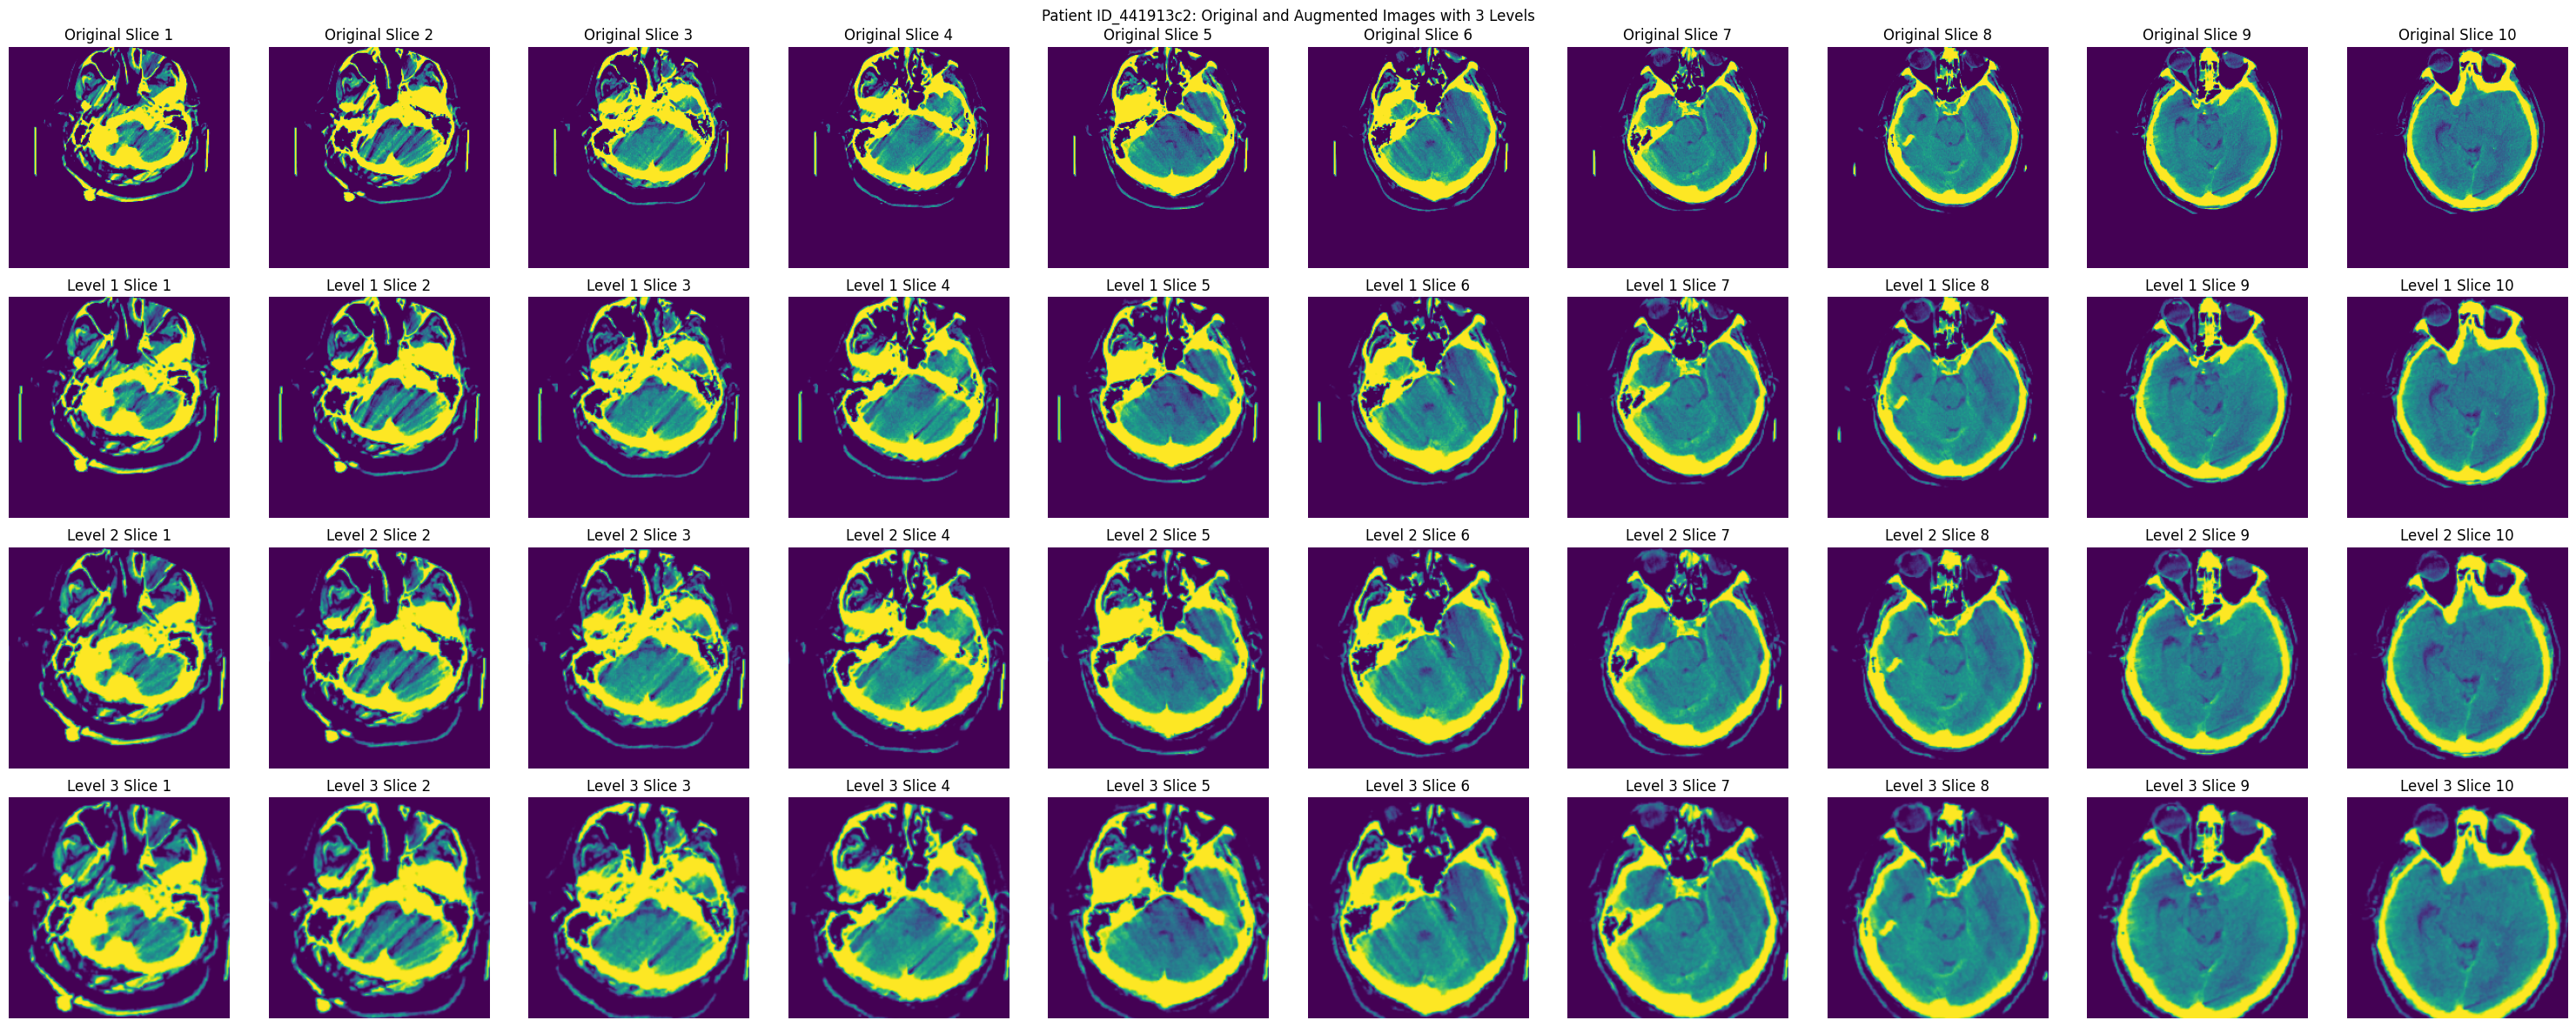

In [22]:
show_original_and_augmented_images(train_df=train_df, dicom_dir=DICOM_DIR, max_slices=10, height=HEIGHT, width=WIDTH, augmentor=augmentor)

# Model configurations

## GP

In [23]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == 512, f"Expected input shape [*, 512] but got {x.shape}"
        
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Attention

In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        assert x.dim() == 3 and x.size(2) == 512, f"Expected input shape [batch_size, num_instances, 512] but got {x.shape}"
        
        attention_weights = self.attention(x)
        weights = nn.functional.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

## ResNet

In [25]:
# 2. Model Definition
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(CHANNELS, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Identity()
        self.dropout = nn.Dropout(p=0.1)
        self.attention = AttentionLayer(input_dim=512, hidden_dim=512)
        
        self.inducing_points = torch.randn(64, 512)
        self.gp_layer = GPModel(self.inducing_points)
        
        self.fc = nn.Linear(512 + 1, 1)
        
    def forward(self, x):
        assert x.dim() == 5 and x.size(1) == MAX_SLICES and x.size(2) == CHANNELS and x.size(3) == HEIGHT and x.size(4) == WIDTH, \
            f"Expected input shape [BATCH_PATIENTS={BATCH_PATIENTS}, MAX_SLICES={MAX_SLICES}, channels={CHANNELS}, height={HEIGHT}, width={WIDTH}] but got {x.shape}"
        
        batch_size, bag_size = x.size(0), x.size(1)
        
        # Reshape to (batch_size * bag_size, channels, height, width)
        x = x.view(-1, *x.shape[2:])
        
        features = self.model(x)

        assert features.shape[1] == 512, f"Expected features to have shape [*, 512] but got {features.shape}"
        
        # Reshape back to (batch_size, bag_size, feature_dim)
        features = features.view(batch_size, bag_size, -1)
        
        attended_features, attended_weights = self.attention(features)

        assert attended_features.shape[1] == 512 and attended_weights.shape[0] == batch_size and attended_weights.shape[1] == bag_size,\
            f"Expected attended_features shape [batch_size={batch_size}, feature_dim=512] but got {attended_features.shape} " \
            f"and attended_weights shape [batch_size={batch_size}, bag_size={bag_size}] but got {attended_weights.shape}"

        attended_features_reshaped = attended_features.view(-1, 512)

        gp_output = self.gp_layer(attended_features_reshaped)
        
        gp_mean = gp_output.mean.view(batch_size, -1)

        combine_features = torch.cat((attended_features, gp_mean), dim=1)
        
        return self.dropout(self.fc(combine_features)), attended_weights

In [26]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


# Loss and optimizer

In [27]:
# 3. Loss and Optimizer
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [28]:
def combined_loss(output, gp_distribution, label, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(output, label.float())
    kl_divergence = gp_distribution.variational_strategy.kl_divergence()
    total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    
    return total_loss

# Train, valid, test functions

In [29]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    for batch_idx, (image, _, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        
        outputs, attention_weights = model(image)
        output = outputs.squeeze()
        label = label.reshape(-1)
        
        loss = combined_loss(output, model.gp_layer, label)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > THRESHOLD).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

        # Collect predictions and labels for metrics
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted_label.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    scheduler.step(epoch_loss)
    return epoch_loss

In [30]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.inference_mode():
        for batch_idx, (image, _, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            outputs, attention_weights = model(image)
            output = outputs.squeeze()
            label = label.reshape(-1)
            
            loss = combined_loss(output, model.gp_layer, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > THRESHOLD).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()

            # Collect predictions and labels for metrics
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
    
    # Calculate metrics
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    return val_loss

In [31]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'checkpoint_epoch_{epoch+1}.pth')    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [32]:
def load_best_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoints found.")
        return None, None

    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True)
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print(f"Checkpoint file: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        return None, None

    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['loss']
        
        print(f"Loaded checkpoint from epoch {epoch+1} with validation loss {best_val_loss}")
        
        return epoch, best_val_loss
    
    except KeyError as e:
        print(f"Error: Checkpoint file is missing expected data: {e}")
        print(f"Available keys in checkpoint: {checkpoint.keys()}")
        return None, None

In [33]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'))
    plt.show()
    plt.close()

In [34]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

In [35]:
def save_final_model(model, optimizer, scheduler, final_model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

In [36]:
def evaluate(model, test_loader, device, criterion):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []
    test_loss = 0

    with torch.inference_mode():
        for image, _, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            outputs, attention_weights = model(image)
            output = outputs.squeeze()
            label = label.reshape(-1)
            
            loss = combined_loss(output, model.gp_layer, label)
            test_loss += loss.item()
            
            predicted_label = (output > THRESHOLD).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            # Collect predictions and labels for metrics
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    
    print(f'Test Accuracy: {accuracy:.4f}%, Test Loss: {avg_loss:.4f}')
    print(f'Test F1 Score: {f1:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}')
    
    # Plot metrics
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

    return accuracy, avg_loss

# Main

## Early stopping

In [37]:
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

## Train result

In [38]:
loaded_epoch, loaded_best_val_loss = load_best_checkpoint(model, optimizer, scheduler, CHECKPOINTS_DIR)

if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    best_val_loss = loaded_best_val_loss
else:
    start_epoch = 0
    best_val_loss = float('inf')

train_loader = dataloader_manager.train_loader
validate_loader = dataloader_manager.validate_loader
test_loader = dataloader_manager.test_loader
    
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
    
for epoch in range(start_epoch, NUM_EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = validate(model, validate_loader, criterion, device)
    
#     early_stopping(val_loss)
    
#     if early_stopping.early_stop:
#         print(f"Early stopping triggered at epoch {epoch + 1}")
#         break
    
    if val_loss < best_val_loss:
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        best_val_loss = val_loss

No checkpoints found.
Epoch 1: Loss: 0.2701, Accuracy: 70.1905%, F1 Score: 0.6369, Precision: 0.8145, Recall: 0.5229
Validation Loss: 0.3119, Validation Accuracy: 68.6667%, F1 Score: 0.6519, Precision: 0.7333, Recall: 0.5867
Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_1.pth
Epoch 2: Loss: 0.2087, Accuracy: 78.2857%, F1 Score: 0.7492, Precision: 0.8867, Recall: 0.6486
Validation Loss: 0.3048, Validation Accuracy: 73.3333%, F1 Score: 0.7101, Precision: 0.7778, Recall: 0.6533
Checkpoint saved: /kaggle/working/RSNA-ResNet18/checkpoints/checkpoint_epoch_2.pth
Epoch 3: Loss: 0.1687, Accuracy: 83.0000%, F1 Score: 0.8100, Precision: 0.9180, Recall: 0.7248
Validation Loss: 0.5423, Validation Accuracy: 58.6667%, F1 Score: 0.6990, Precision: 0.5496, Recall: 0.9600
Epoch 4: Loss: 0.1415, Accuracy: 85.0952%, F1 Score: 0.8355, Precision: 0.9320, Recall: 0.7571
Validation Loss: 0.3047, Validation Accuracy: 61.3333%, F1 Score: 0.3958, Precision: 0.9048, Recall: 0.2533


## Evaluate result

Test Accuracy: 72.0000%, Test Loss: 0.4136
Test F1 Score: 0.7342, Test Precision: 0.6988, Test Recall: 0.7733


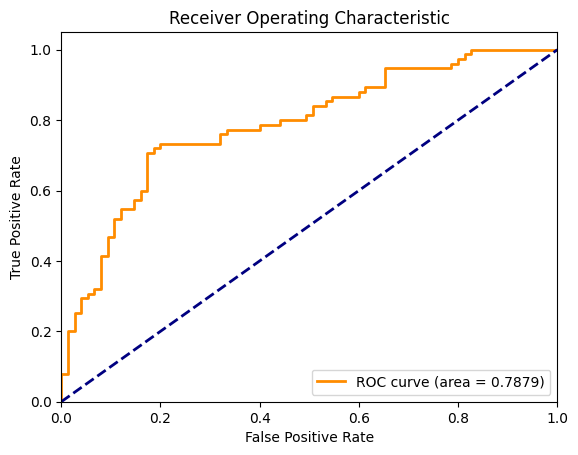

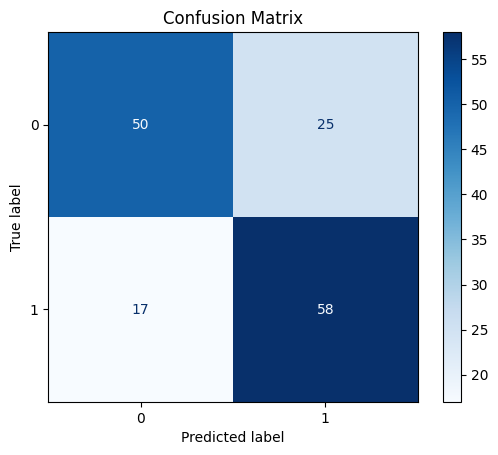

Final model saved to /kaggle/working/RSNA-ResNet18/checkpoints/final_model.pth


In [39]:
accuracy, test_loss = evaluate(model, test_loader, device, criterion)

final_model_path = os.path.join(CHECKPOINTS_DIR, 'final_model.pth')
save_final_model(model, optimizer, scheduler, final_model_path)

# Plot with attention

In [40]:
def plot_images_with_attention(test_loader, model, device):
    model.eval()
    found_labels = {0: False, 1: False}
    with torch.no_grad():
        for image, _, label in test_loader:
            image, label = image.to(device), label.to(device)
            outputs, attention_weights = model(image)
            attention_weights = attention_weights.view(image.size(0), -1)
            for i in range(image.size(0)):
                patient_label = label[i].item()
                
                if patient_label in [0, 1] and not found_labels[patient_label]:
                    found_labels[patient_label] = True
                    
                    plt.figure(figsize=(16, 8))
                    fig, axes = plt.subplots(10, 6, figsize=(16, 24))
                    for j in range(MAX_SLICES):
                        if j < image.size(1):
                            ax = axes[j // 6, j % 6]
                            ax.imshow(image[i, j].cpu().numpy().transpose(1, 2, 0))
                            ax.axis('off')
                            ax.set_title(f'Attention: {attention_weights[i][j].item():.4f}', fontsize=10)
                    fig.suptitle(f'Patient Label: {patient_label}', fontsize=16)
                    fig.subplots_adjust(top=0.9)
                    plt.show()
                if all(found_labels.values()):
                    return

<Figure size 1600x800 with 0 Axes>

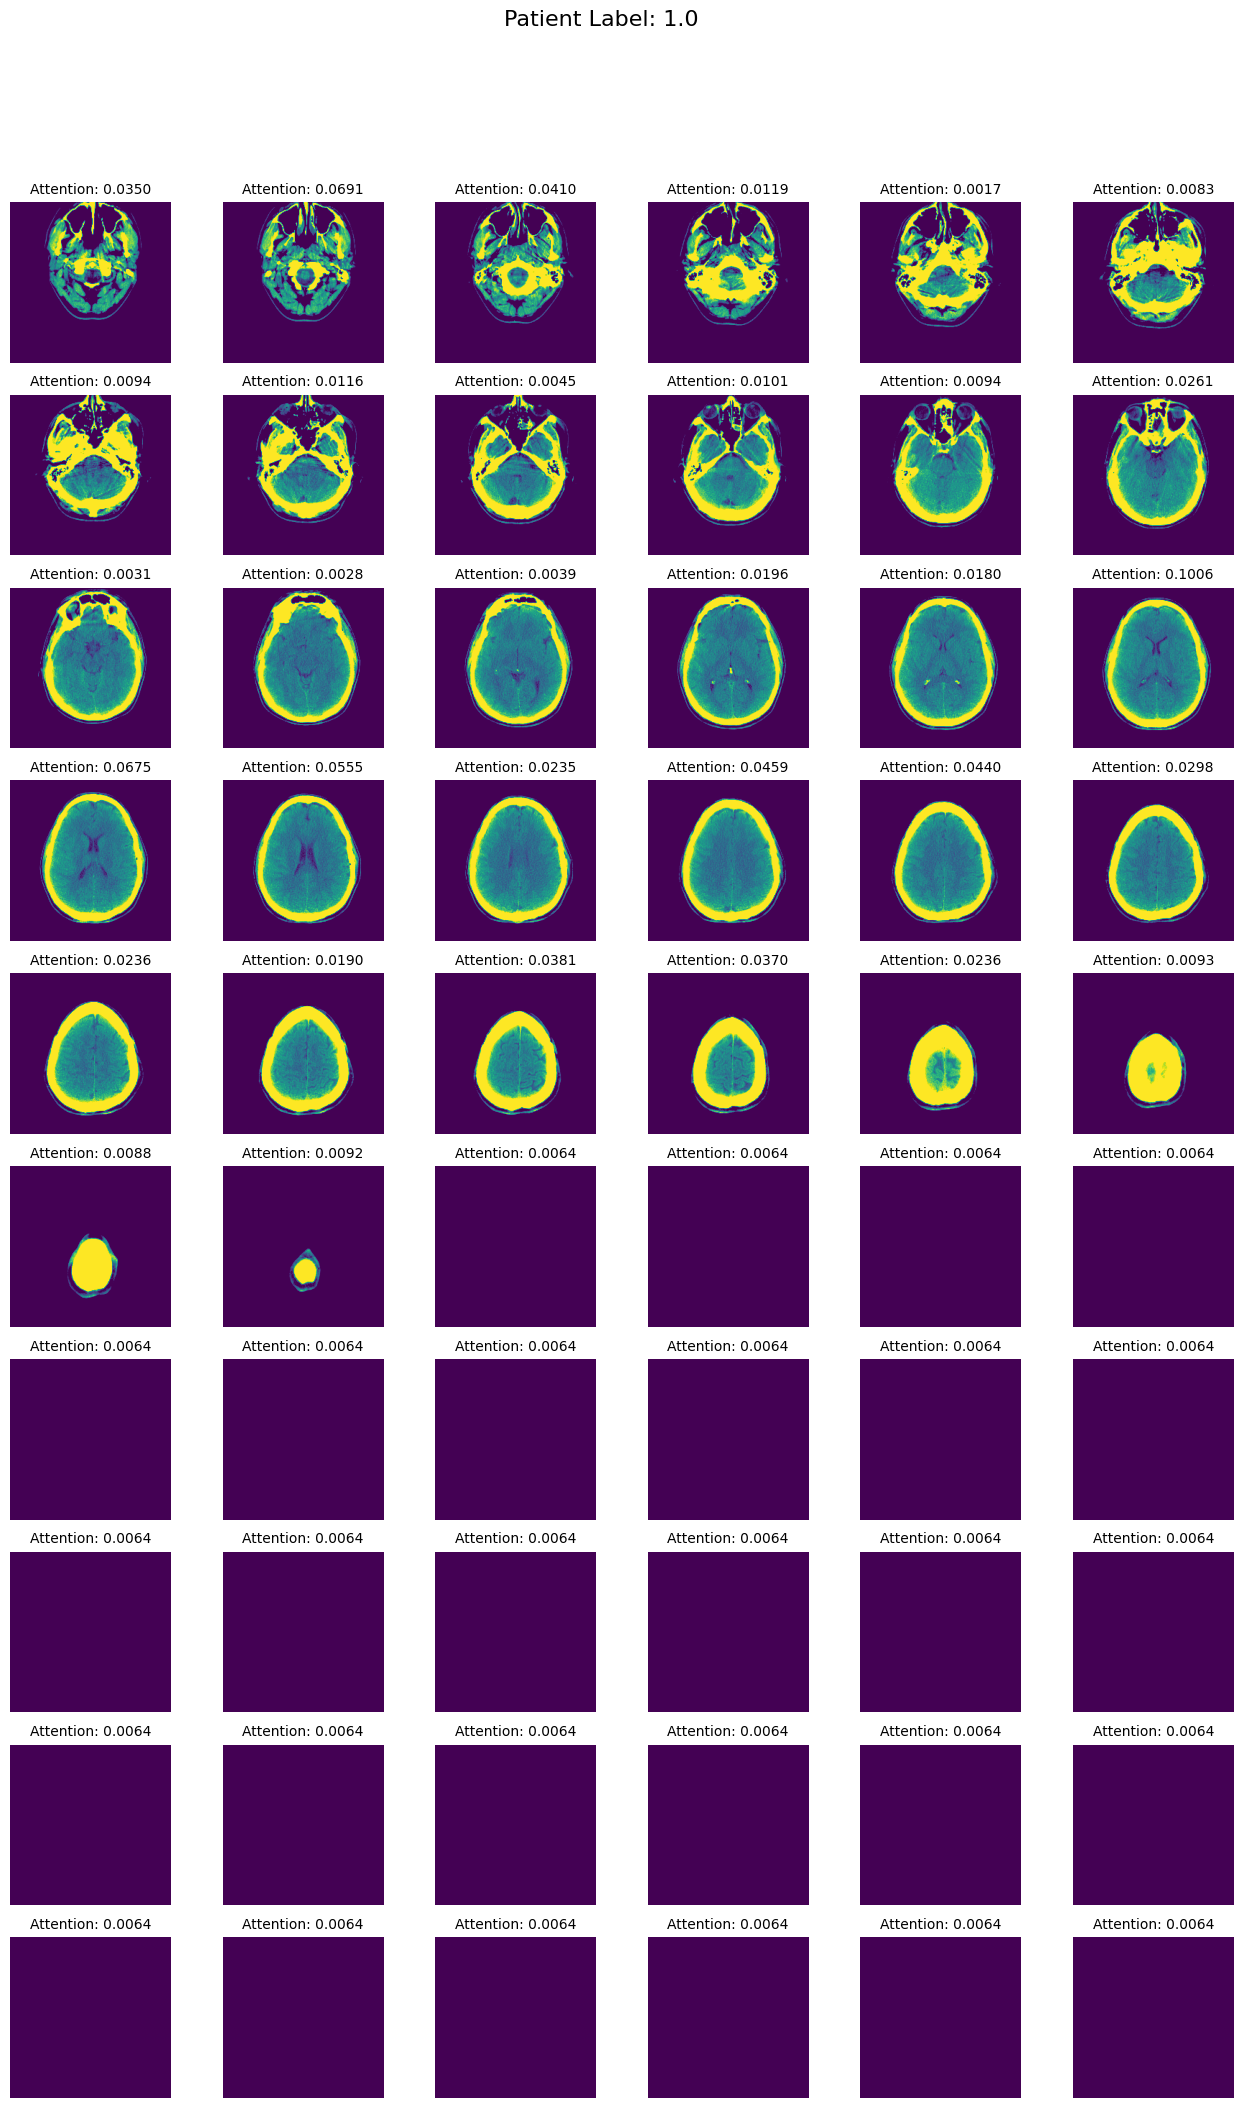

<Figure size 1600x800 with 0 Axes>

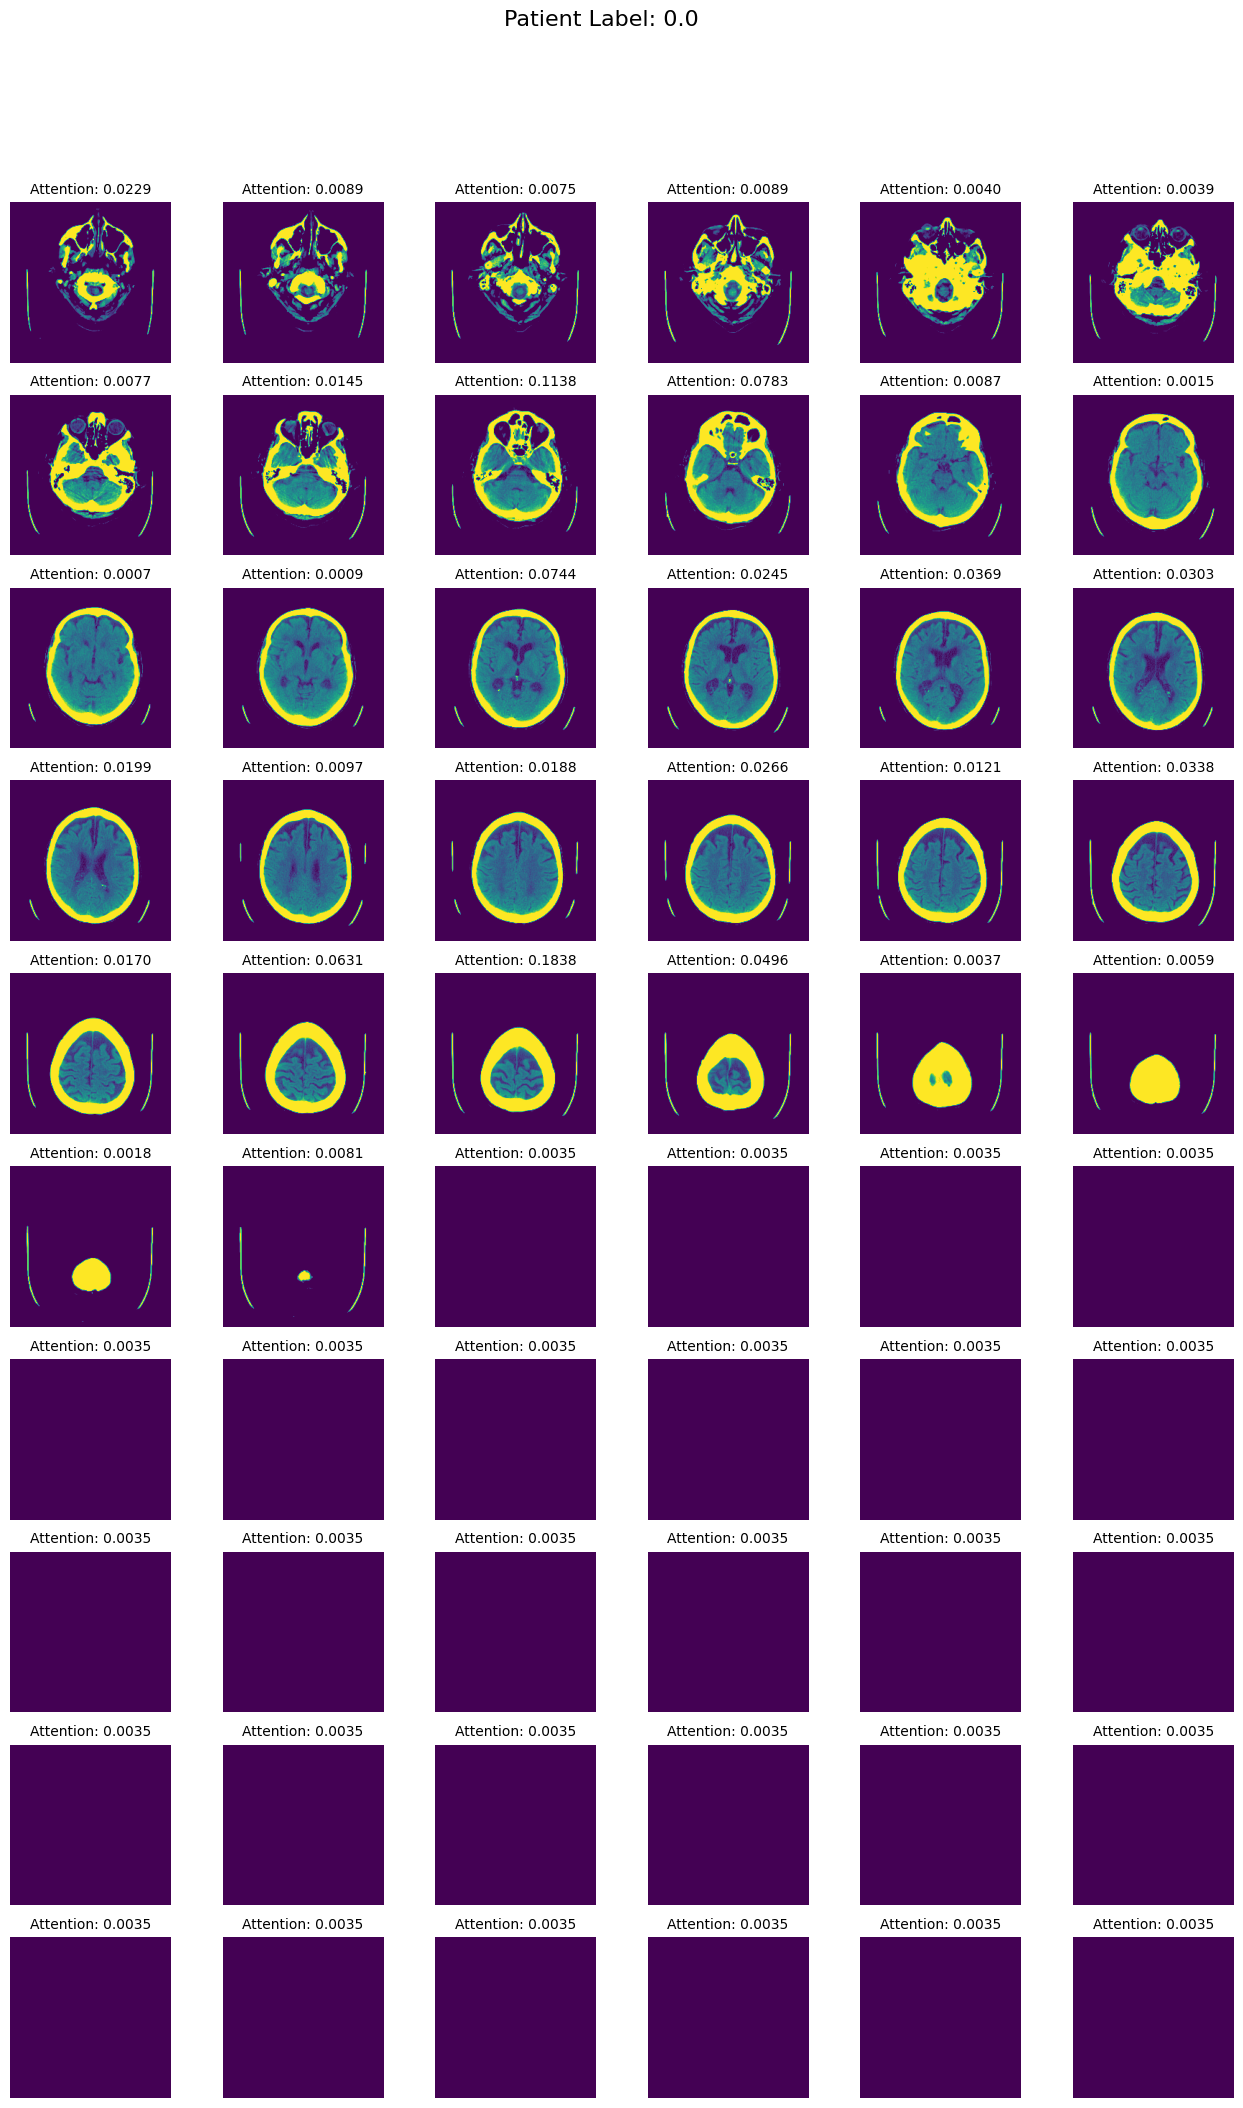

In [41]:
plot_images_with_attention(test_loader, model, device)